# Creating 3D Travel Time Model and Function

In [1]:
# Import libraries
import pyekfmm as fmm
import numpy as np
import pandas as pd
import json
import pyproj
import matplotlib.pyplot as plt

## We will need a code routine for center and make an square of 130.5 x 130.5 kilometers

#### Project the velocity model to the initial coordinate used by CNQ

#### Define station (CI.CLC) coodinates

In [2]:
# Load the array vp and vs from the .npy file
velp = np.load('/Users/lamb/Documents/Modelo_Velocidades/EWnMix2/vp.npy')
vels = np.load('/Users/lamb/Documents/Modelo_Velocidades/EWnMix2/vs.npy')

In [3]:
velp

array([[[5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        ...,
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18]],

       [[5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        ...,
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18]],

       [[5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        ...,
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18],
        [5.5 , 5.5 , 5.5 , ..., 8.18, 8.18, 8.18]],

       ...,

       [[5.5 , 5.5 , 5.5

In [4]:
velp.shape

(255, 255, 255)

(255.0, 0.0)

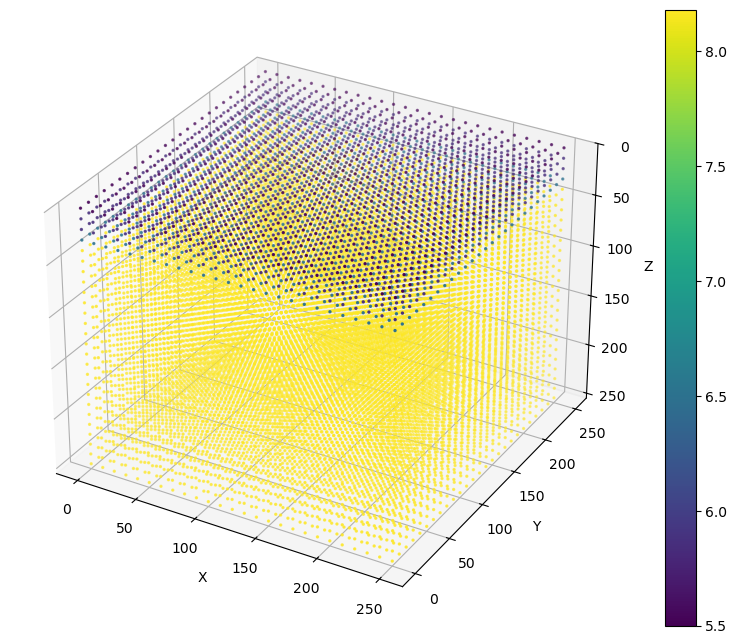

In [5]:
from mpl_toolkits.mplot3d import Axes3D
# Reducir el tamaño de la muestra (cada 10 puntos en cada eje)
x, y, z = np.mgrid[0:velp.shape[0]:10, 0:velp.shape[1]:10, 0:velp.shape[2]:10]
velp_downsampled = velp[::10, ::10, ::10]

# Aplanar los arrays para poder graficarlos
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
v_flat = velp_downsampled.flatten()

# Crear el gráfico 3D con scatter
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos en 3D
sc = ax.scatter(x_flat, y_flat, z_flat, c=v_flat, cmap='viridis', s=2)

# Añadir una barra de colores que representa los valores de velocidad
plt.colorbar(sc)

# Etiquetas de los ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(255, 0) 

In [6]:
# Reshape the 'new_velp' matrix to a one-dimensional array with column-major order
vpp = velp.reshape([255*255*255,1], order='F').astype('float32')

In [7]:
vpp

array([[5.5 ],
       [5.5 ],
       [5.5 ],
       ...,
       [8.18],
       [8.18],
       [8.18]], dtype=float32)

In [8]:
#vpp[1] =5.5
vpp

array([[5.5 ],
       [5.5 ],
       [5.5 ],
       ...,
       [8.18],
       [8.18],
       [8.18]], dtype=float32)

In [9]:
# Reshape the 'new_vels' matrix to a one-dimensional array with column-major order
vss = vels.reshape([255*255*255,1],order='F').astype('float32')

In [10]:
vss

array([[3.06],
       [3.06],
       [3.06],
       ...,
       [4.54],
       [4.54],
       [4.54]], dtype=float32)

In [11]:
vss.max()

4.54

### Source

In [12]:
#Lat: 31.408922          lon: -103.510147
stax = [-103.510147]    #Longitude of CI.CLC
stay = [31.408922]    # latitude of CI.CLC

input_crs = pyproj.CRS("EPSG:4326")  # EPSG:4326 represents WGS 84 (latitude and longitude)

# Define the output coordinates system (latitude and longitude)
output_crs = pyproj.CRS("EPSG:3857")

# Create a coordinates transformer
transformer = pyproj.Transformer.from_crs(input_crs, output_crs, always_xy=True)

# Transform the latitude and longitude station (CI.CLC) coodinates
stax_pro, stay_pro = transformer.transform(stax, stay)

print(stax_pro, stay_pro)

[-11522696.855976894] [3685970.0986554055]


In [13]:
# Limites de velp y vels
#minx: -11669823.762683755, miny: 3583642.4713136116
#Elementos en x: 218, Elementos en y: 255
stax_pro = stax_pro[0] - -11669823.762683755
stay_pro = stay_pro[0] - 3583642.4713136116
stax_pro = int(stax_pro/1000)
stay_pro = int(stay_pro/1000)
print(stax_pro, stay_pro)

147 102


# Calcuating 3D Travel Times based on Eikonal's Function

## This code was modified from Yangkang Chen, 2022, The University of Texas at Austin.

In [14]:
#error por tener 0 en el arreglo

In [67]:
# Caulculate P and S wave times based on Eikonal's function
tp = fmm.eikonal(vpp, xyz=np.array([stay_pro,stax_pro,0]),ax=[0,1,255],ay=[0,1,255],az=[0,1,255],order=2);
ts = fmm.eikonal(vss, xyz=np.array([stay_pro, stax_pro,0]),ax=[0,1,255],ay=[0,1,255],az=[0,1,255],order=2);

In [68]:
print(tp.max())
print(ts.max())

42.51272
76.58331


In [69]:
# Reshape the 'tp' and 'ts' matrix to a one-dimensional array with column-major order
ttp = tp.reshape(255,255,255,order='F')
tts = ts.reshape(255,255,255,order='F')

In [70]:
# Calculate the difference between P ans S times
tsp = tts - ttp

In [71]:
tsp.min()

0.0

In [72]:
# Extract the first layer (index 0) along the third dimension from the 'tsp' matrix
tn = tsp[:,:,1]
# This will be used for the contour plot

In [73]:
# Reshape the 2D array 'tn' to have dimensions (261, 261)
tn = tn.reshape(255, 255)

In [74]:
tn.max()

27.670307

#### Contour plot

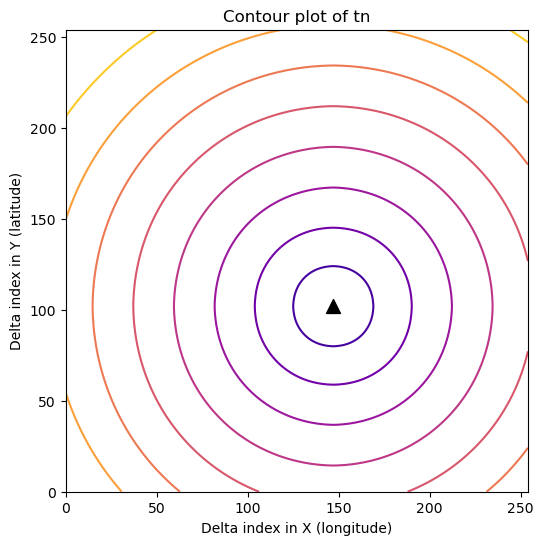

In [75]:
# Plot contour times plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111,aspect=1.0)
plt.contour(tn, levels=np.linspace(tn.min(), tn.max(), 10))
plt.scatter(stax_pro,stay_pro,s=100,marker='^',color='black', label='CI.CLC')
plt.xlabel('Delta index in X (longitude)')
plt.ylabel('Delta index in Y (latitude)')
plt.title('Contour plot of tn')

# Show the plot
plt.show()

In [76]:
tsp.shape

(255, 255, 255)

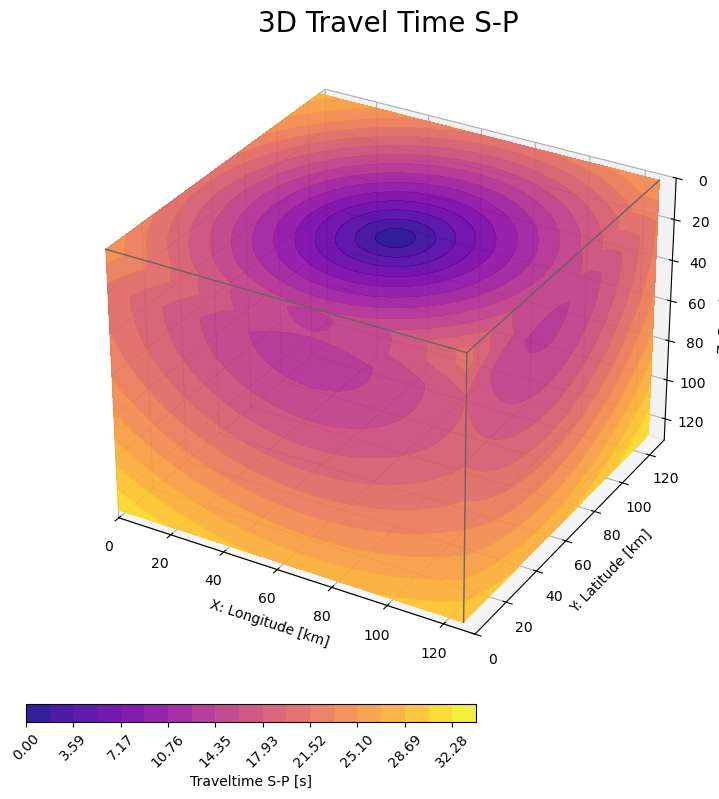

In [77]:
#Modified from Yangkang Chen, 2022. The University of Texas at Austin.

# Define matrix dimensions
Nx, Ny, Nz = 255, 255, 255
X, Y, Z = np.meshgrid(np.arange(Nx)*.5, np.arange(Ny)*.5, np.arange(Nz)*.5)

# Specify the 3D data
data = tsp
kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'alpha': 0.9,
    'levels': np.linspace(data.min(), data.max(), 20),
}

# Create a figure with 3D axes
fig = plt.figure(figsize=(18, 9))
# plt.subplot(1,2,1)
plt.plasma()
ax = fig.add_subplot(121, projection='3d')

# Plot contour surfaces
_ = ax.contourf(X[:, :, -1], Y[:, :, -1], data[:, :, 0], zdir='z', offset=0, **kw)
_ = ax.contourf(X[0, :, :], data[0, :, :], Z[0, :, :], zdir='y', offset=0, **kw)
C = ax.contourf(data[:, -1, :], Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)

# Set limits of the plot from coordinates limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

#Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
#ax.set(xlabel='X: Longitude [km]', ylabel='Y: Latitude [km]', zlabel='Z: Depth [km]')
ax.set_xlabel('X: Longitude [km]')
ax.set_ylabel('Y: Latitude [km]')
ax.set_zlabel('Z: Depth [km]')

# Set zoom and angle view
# ax.view_init(40, -30, 0)
# ax.set_box_aspect(None, zoom=0.9)         stax_pro,stay_pro

#plt.gca().scatter(stax_pro, stay_pro, 0, s=100, marker='^', color='black', label='CI.CLC') #(x, y, z)
plt.gca().set_xlim(0,131);
plt.gca().set_ylim(0,131);
plt.gca().set_zlim(0,131)
plt.title('3D Travel Time S-P', color='k', fontsize=20)
plt.gca().invert_zaxis()

# Position for the colorbar
#cb = plt.colorbar(C, cax = fig.add_axes([0.15,0.1,0.3,0.02]), format= "%4.2f", orientation='horizontal',label='Traveltime S-P [s]')
cb = plt.colorbar(C, cax=fig.add_axes([0.10, 0.09, 0.25, 0.02]), format="%4.2f", orientation='horizontal', label='Traveltime S-P [s]')
cb.ax.tick_params(labelrotation=45)
# Save image plot
plt.savefig('test_pyekfmm_fig2.png',format='png',dpi=300,bbox_inches='tight', pad_inches=0.3)
plt.savefig('test_pyekfmm_fig2.pdf', format='pdf', dpi=350, bbox_inches='tight', pad_inches=0.1)


# Show Figure
plt.show()

In [26]:
type(tsp)

numpy.ndarray

In [28]:
vpp.shape

(16581375, 1)

In [26]:
np.save('tp_s.npy',tsp)

# Define Travel Time Function of 3D Coordinates

In [29]:
def get_travel_time(X,Y,Z):
    # Redondea las coordenadas X, Y y Z a las divisiones del grid de 500 metros
    X_rounded = round(X / 500) * 500
    Y_rounded = round(Y / 500) * 500
    Z_rounded = round(Z / 500) * 500
    # Encuentra los índices correspondientes en el arreglo tsp
    x_index = int(X_rounded / 500)
    y_index = int(Y_rounded / 500)
    z_index = int(Z_rounded / 500)
    # Obtiene el valor del tiempo en el arreglo tsp usando los índices
    print(x_index, y_index, z_index)
    time = tsp[x_index, y_index, z_index]

    return time

In [33]:
t = get_travel_time(CLCx, CLCy, 0)

111 136 0


In [34]:
t

1.4839413